In [67]:
import numpy as np
from src.utils import compute_log_area
from src.ms import MarginalScreeningNorm
from sicore import RealSubset, SelectiveInferenceResult, truncated_cdf
from scipy.stats import norm
from scipy.optimize import brentq, minimize
from scipy.integrate import quad
from tqdm import tqdm
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import warnings

warnings.filterwarnings(action="once")


In [84]:
def randomized_inference(
    rng: np.random.Generator,
    n: int = 100,
    d: int = 10,
    delta: float = 0.0,
    sigma: float = 1.0,
    k: int = 3,
    tau: float = 1.0,
):
    beta = delta * np.ones(d)
    X = rng.normal(size=(n, d))
    y = X @ beta + rng.normal(size=n, scale=sigma)
    omega = rng.normal(size=n, scale=tau)

    ms = MarginalScreeningNorm(X, y + omega, np.sqrt(sigma ** 2 + tau ** 2), k)
    result: SelectiveInferenceResult = ms.inference(rng.integers(k), inference_mode="exhaustive")

    # prepare for randomized inference
    sigma_ = sigma * np.linalg.norm(ms.eta, ord=2)
    tau_ = tau * np.linalg.norm(ms.eta, ord=2)
    truncated_region  = RealSubset(np.array(result.truncated_intervals) * np.sqrt(sigma_**2 + tau_**2))
    stat = ms.eta @ y

    # compute p-value with randomization
    pivot = compute_randomized_cdf(stat, sigma_, tau_, truncated_region, 0.0)
    p_randomized = 2.0 * min(pivot, 1.0 - pivot)

    # compute CI with randomization
    true_signal = ms.eta @ (X @ beta)
    ci_lower = brentq(
        lambda mu: compute_randomized_cdf(stat, sigma_, tau_, truncated_region, mu) - 0.95,
        -20.0,
        20.0,
    )
    ci_upper = brentq(
        lambda mu: compute_randomized_cdf(stat, sigma_, tau_, truncated_region, mu) - 0.05,
        -20.0,
        20.0,
    )
    is_contain = (ci_lower <= true_signal) and (true_signal <= ci_upper)

    # compute MLE with randomization
    mle = minimize(
        lambda mu: -compute_randomized_pdf(
            stat, sigma_, tau_, truncated_region, mu,
        ),
        x0=0.0,
    ).x[0]

    return true_signal, p_randomized, [ci_lower, ci_upper], is_contain, mle

def compute_randomized_cdf(
    stat: float,
    sigma: float,
    tau: float,
    truncated_region: RealSubset,
    mu: float,
):
    rho_sq = tau**2 / (sigma**2 + tau**2)
    log_denominator = compute_log_area(norm(loc=mu, scale=np.sqrt(sigma**2 + tau**2)), truncated_region)
    def integrand(v):
        log_numerator = norm.logcdf(stat, loc=rho_sq * mu + (1 - rho_sq) * v, scale=sigma * np.sqrt(rho_sq))
        return np.exp(norm.logpdf(v, loc=mu, scale=np.sqrt(sigma**2 + tau**2)) + log_numerator - log_denominator)
    pivot = 0.0
    for interval in truncated_region:
        a, b = interval
        pivot += quad(integrand, a, b)[0]
    return pivot

def compute_randomized_pdf(
    stat: float,
    sigma: float,
    tau: float,
    truncated_region: RealSubset,
    mu: float,
):
    rho_sq = tau**2 / (sigma**2 + tau**2)
    log_denominator = compute_log_area(norm(loc=mu, scale=np.sqrt(sigma**2 + tau**2)), truncated_region)
    def integrand(v):
        log_numerator = norm.logpdf(stat, loc=rho_sq * mu + (1 - rho_sq) * v, scale=sigma * np.sqrt(rho_sq))
        return np.exp(norm.logpdf(v, loc=mu, scale=np.sqrt(sigma**2 + tau**2)) + log_numerator - log_denominator)
    pivot = 0.0
    for interval in truncated_region:
        a, b = interval
        pivot += quad(integrand, a, b)[0]
    return pivot


In [87]:
base_rng = np.random.default_rng(612907)
n, d = 100, 10
k = 3
delta = 0.2
sigma = 1.0
tau = 1.0

true_signal_list = []
p_list = []
ci_list = []
is_contain_list = []
mle_list = []

results = Parallel(n_jobs=48)(
    delayed(randomized_inference)(rng, n=n, d=d, delta=delta, sigma=sigma, k=k, tau=tau)
    for rng in tqdm(base_rng.spawn(2000))
)

for true_signal, p, ci, is_contain, mle in results:
    true_signal_list.append(true_signal)
    p_list.append(p)
    ci_list.append(ci)
    is_contain_list.append(is_contain)
    mle_list.append(mle)


100%|██████████| 2000/2000 [00:42<00:00, 47.42it/s]


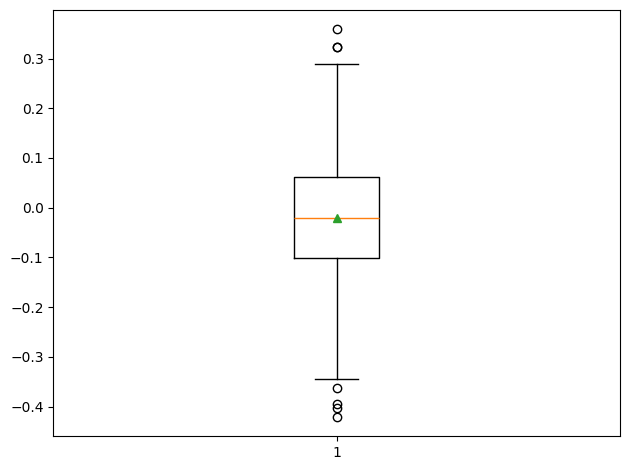

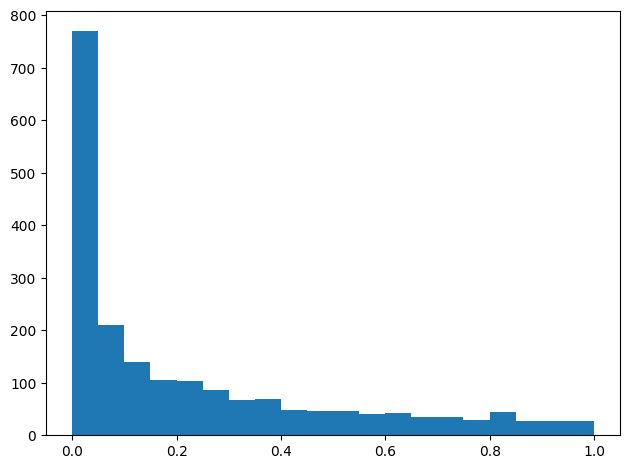

0.893


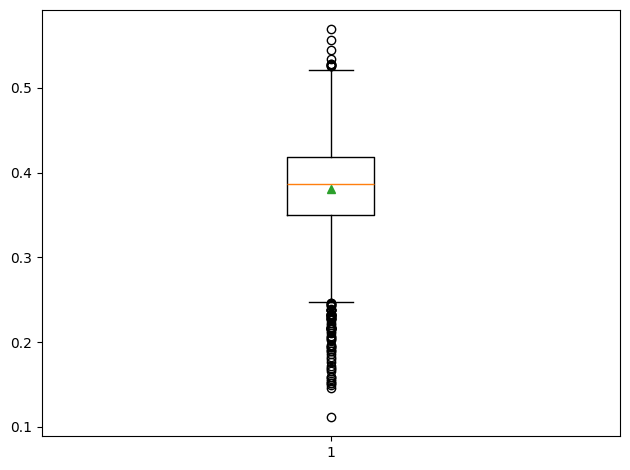

In [88]:
plt.boxplot(np.array(mle_list) - np.array(true_signal_list), showmeans=True)
# plt.ylim(-0.5, 0.5)
plt.show()

plt.hist(p_list, bins=20)
plt.show()

ci_array = np.array(ci_list)
lengths = ci_array[:, 1] - ci_array[:, 0]
print(np.mean(is_contain_list))
plt.boxplot(lengths, showmeans=True)
# plt.ylim(0, 5)
plt.show()


In [ ]:
def polyhedral_inference(
    rng: np.random.Generator,
    n: int = 100,
    d: int = 10,
    delta: float = 0.0,
    sigma: float = 1.0,
    k: int = 3,
):
    beta = delta * np.ones(d)
    X = rng.normal(size=(n, d))
    y = X @ beta + rng.normal(size=n, scale=sigma)

    ms = MarginalScreeningNorm(X, y, sigma, k)
    result: SelectiveInferenceResult = ms.inference(rng.integers(k), inference_mode="exhaustive")

    p_value = result.p_value

    stat_sigma = sigma * np.linalg.norm(ms.eta, ord=2)
    truncated_region = RealSubset(np.array(result.truncated_intervals) * stat_sigma)
    stat = result.stat * stat_sigma

    a, b = -10.0, 10.0
    while True:
        val_a = truncated_cdf(norm(loc=a, scale=stat_sigma), stat, truncated_region) - 0.95
        val_b = truncated_cdf(norm(loc=b, scale=stat_sigma), stat, truncated_region) - 0.95
        if val_a * val_b < 0:
            break
        a *= 2
        b *= 2
    ci_lower = brentq(
        lambda mu: truncated_cdf(norm(loc=mu, scale=stat_sigma), stat, truncated_region) - 0.95,
        a,
        b,
    )

    a, b = -10.0, 10.0
    while True:
        val_a = truncated_cdf(norm(loc=a, scale=stat_sigma), stat, truncated_region) - 0.05
        val_b = truncated_cdf(norm(loc=b, scale=stat_sigma), stat, truncated_region) - 0.05
        if val_a * val_b < 0:
            break
        a *= 2
        b *= 2
    ci_upper = brentq(
        lambda mu: truncated_cdf(norm(loc=mu, scale=stat_sigma), stat, truncated_region) - 0.05,
        a,
        b,
    )

    true_signal = ms.eta @ (X @ beta)
    is_contain = (ci_lower <= true_signal) and (true_signal <= ci_upper)

    mle = minimize(
        lambda mu: -norm.logpdf(stat, loc=mu, scale=stat_sigma) + compute_log_area(norm(loc=theta, scale=stat_sigma), truncated_region),
        x0=0.0,
    ).x[0]
    return true_signal, p_value, [ci_lower, ci_upper], is_contain, mle


In [ ]:
base_rng = np.random.default_rng(0)
n, d = 100, 10
k = 3
delta = 0.0
sigma = 1.0

true_signal_list = []
p_list = []
ci_list = []
is_contain_list = []
mle_list = []

results = Parallel(n_jobs=48)(
    delayed(polyhedral_inference)(rng, n=n, d=d, delta=delta, sigma=sigma, k=k)
    for rng in tqdm(base_rng.spawn(500))
)

for true_signal, p, ci, is_contain, mle in results:
    true_signal_list.append(true_signal)
    p_list.append(p)
    ci_list.append(ci)
    is_contain_list.append(is_contain)
    mle_list.append(mle)


100%|██████████| 500/500 [00:01<00:00, 414.56it/s]


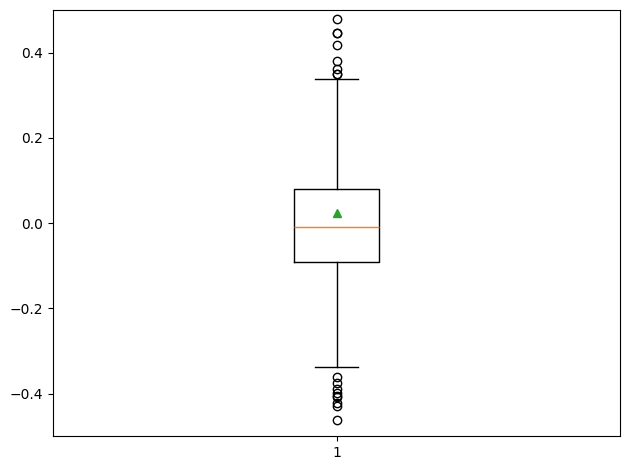

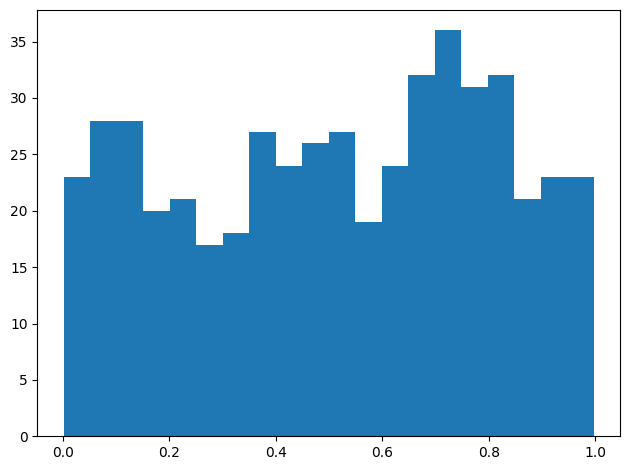

0.904


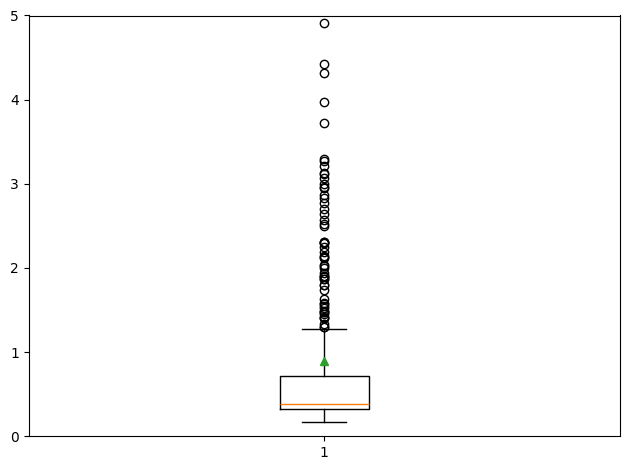

In [ ]:
plt.boxplot(np.array(mle_list) - np.array(true_signal_list), showmeans=True)
plt.ylim(-0.5, 0.5)
plt.show()

plt.hist(p_list, bins=20)
plt.show()

ci_array = np.array(ci_list)
lengths = ci_array[:, 1] - ci_array[:, 0]
print(np.mean(is_contain_list))
plt.boxplot(lengths, showmeans=True)
plt.ylim(0, 5)
plt.show()
